# Using SignalP 6.0 to investigate signal peptide regions

In addition to predicting the type and the cleavage site of SPs, SignalP 6.0 predicts the regions of SPs.

SPs all follow a distinct region organization. They start with a positively charged n-region, followed by a hydrophobic h-region, and end with a polar c-region. Lipoprotein SPs lack a c-region, and Sec/SPIII SPs only consist of one single region.

<br/>
<p align="center">
    <img width="50%" src="media/sp_regions.png" alt="SP Regions">
</p>
<br/>

In this notebook we showcase how the region predictions of SignalP 6.0 can be used for detailed biochemical characterization of SPs.

## Aim of experiment
In this example we use the data from **Signal Peptides Generated by Attention-Based Neural Networks** (https://pubs.acs.org/doi/10.1021/acssynbio.0c00219). Wu et al. trained a transformer model to generate SP sequences conditional on the sequence of a mature protein that is to be exported from the cell. However, they found that not all generated SPs are functional when tested experimentally in *B. subtilis*. Also, it turned out that SignalP 5.0 was not able to discriminate functional from non-functional SPs.

Note that SignalP 5.0 (as SignalP 6.0) is a general predictor of SPs, not specific for *B. subtilis*. We thus suspected that there are specific constraints for *B. subtilis* SPs that the models don't know about. We investigate this hypothesis by using SignalP 6.0 region predictions for biochemical characterization.

First, we need to obtain predictions for the data we want to investigate. We use the SignalP 6.0 webserver for that, download the output as zip file and unzip it.

## Investigation

The repo includes utility functions that compute the biochemical properties for us. Given an unzipped directory, we obtain a dataframe of the region properties.

- `len`: Length
- `rel_len`: Relative length
- `hyd`: Kyte-Doolittle hydrophobicity
- `chr`: Net charge at pH 7

__NOTE:__ The function does not check for organism groups at the moment. In case of Eukarya and Archaea, +1 would need to be added to `chr_c` and `chr_sp`.

In [36]:
from signalp6.utils import region_features_from_server_output
import pandas as pd

df = region_features_from_server_output('data/predictions_synthetic_sps/')
df = df.loc[df['SP type']=='signal_peptide']

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [37]:
df.head()

,ID,SP type,len_n,len_h,len_c,len_sp,rel_len_n,rel_len_h,rel_len_c,hyd_n,hyd_h,hyd_c,hyd_sp,chr_n,chr_h,chr_c,chr_sp
0,Gen_005_Arnold_001_0,signal_peptide,3.0,13.0,2.0,21,0.142857,0.619048,0.095238,7.2,23.2,-1.1,29.3,0.0,0.0,1.0,1.0
1,Gen_006_Arnold_001_1,signal_peptide,2.0,15.0,4.0,24,0.083333,0.625000,0.166667,0.8,24.1,1.2,26.1,1.0,1.0,0.0,2.0
2,Gen_007_Arnold_001_0,signal_peptide,2.0,13.0,3.0,21,0.095238,0.619048,0.142857,-5.9,25.9,2.2,22.2,2.0,0.0,1.0,3.0
3,Gen_009_Arnold_002_1,signal_peptide,1.0,13.0,4.0,21,0.047619,0.619048,0.190476,-2.6,28.1,0.9,26.4,1.0,0.0,-1.0,0.0
4,Gen_009_Arnold_039_0,signal_peptide,1.0,12.0,3.0,19,0.052632,0.631579,0.157895,-2.6,26.3,6.6,30.3,1.0,0.0,0.0,1.0


For this specific dataset, the `ID` contains the information whether the SP was functional in E. coli or not.

In [38]:
df['Functional'] = df['ID'].apply(lambda x: x.split('_')[-1])

Now we're ready to compare the two groups. We use seaborn for plotting and statannot to automatically add t-tests to our comparison. Let's look at the net charges first.

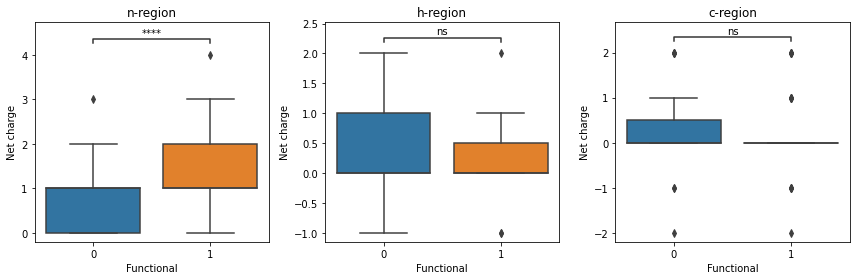

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

ylab= 'Net charge'
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
y='chr_n' # Choose the feature we want to plot from the df
ax = sns.boxplot(data=df, x='Functional', y=y)
test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                   box_pairs=[('0', '1')],
                                   test='t-test_welch', text_format='star',
                                   loc='inside', verbose=0)


plt.title('n-region')
plt.ylabel(ylab)

plt.subplot(1,3,2)
y='chr_h'
ax = sns.boxplot(data=df, x='Functional', y=y)
test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                   box_pairs=[('0', '1')],
                                   test='t-test_welch', text_format='star',
                                   loc='inside', verbose=0)
plt.title('h-region')
plt.ylabel(ylab)
plt.subplot(1,3,3)
y='chr_c'
ax = sns.boxplot(data=df, x='Functional', y=y)
test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                   box_pairs=[('0', '1')],
                                   test='t-test_welch', text_format='star',
                                   loc='inside', verbose=0)
plt.title('c-region')
plt.ylabel(ylab)

plt.tight_layout()


We find that there is a clear difference in n-region net charges. The n-region is expected to be positively charged. It appears that for nonfunctional SPs, the charge is lower than for functional SPs.

Let's make the analysis more insightful. Instead of just comparing the synthetic SPs, we also include wild type *B.subtilis* SPs. For this, we predict all *B. subtilis* SPs with experimental evidence in UniProt.

In [40]:
df_bsubtilis= region_features_from_server_output('data/b_subtilis_sps/')

#add a Functional column
df_bsubtilis['Functional'] = 'WT'
df_bsubtilis = df_bsubtilis.loc[df_bsubtilis['SP type']=='signal_peptide']

#put both datasets together
df = pd.concat([df, df_bsubtilis])

/mnt/c/Users/felix/Coding/protein_modeling/testenv/lib/python3.6/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [41]:
# let's define a function to make the boxplots
def compare_feature_plot(df, title, feature):
    ylab= title
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    y=feature+'_n' # Choose the feature we want to plot from the df
    ax = sns.boxplot(data=df, x='Functional', y=y)
    test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                       box_pairs=[('0', '1'),('0', 'WT'),('1', 'WT')],
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=0)


    plt.title('n-region')
    plt.ylabel(ylab)

    plt.subplot(1,3,2)
    y=feature+'_h'
    ax = sns.boxplot(data=df, x='Functional', y=y)
    test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                       box_pairs=[('0', '1'),('0', 'WT'),('1', 'WT')],
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=0)
    plt.title('h-region')
    plt.ylabel(ylab)
    plt.subplot(1,3,3)
    y= feature+'_c'
    ax = sns.boxplot(data=df, x='Functional', y=y)
    test_results = add_stat_annotation(ax, data=df, x='Functional', y=y, #order=order,
                                       box_pairs=[('0', '1'),('0', 'WT'),('1', 'WT')],
                                       test='t-test_welch', text_format='star',
                                       loc='inside', verbose=0)
    plt.title('c-region')
    plt.ylabel(ylab)

    plt.tight_layout()


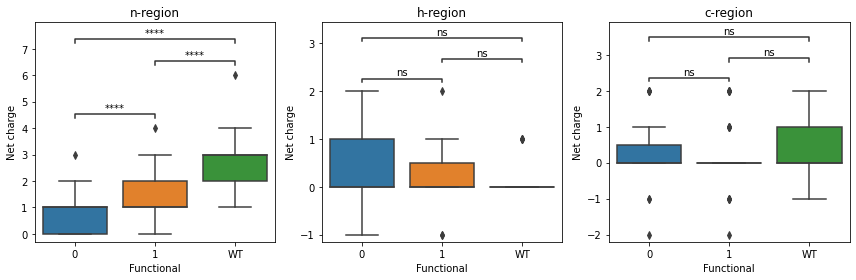

In [42]:
compare_feature_plot(df, 'Net charge', 'chr')

The extended anysis shows that wild-type SPs have an even higher n-region net charge than the synthetic functional SPs. This could hint at the net charge of nonfunctional SPs being too low for secretion.

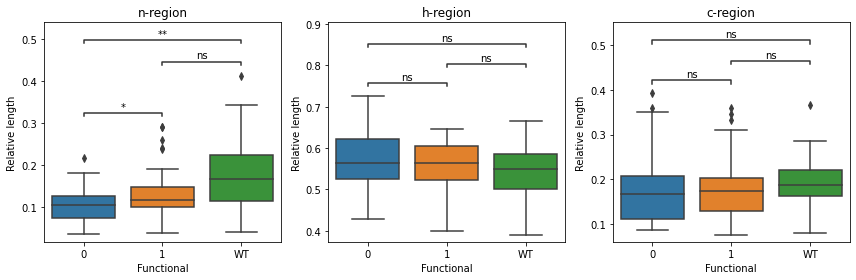

In [44]:
compare_feature_plot(df, 'Relative length', 'rel_len')

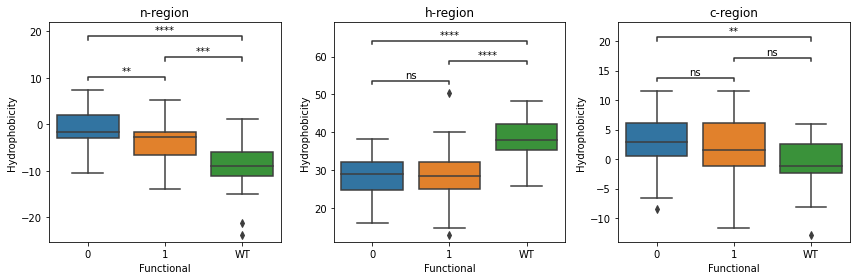

In [45]:
compare_feature_plot(df, 'Hydrophobicity', 'hyd')

We discover further differences between the groups. Overall, synthetic SPs still seem to have major differences in biochemistry to natural SPs in *B. subtilis* irrespective of their functionality status. 